<a href="https://colab.research.google.com/github/ASIF-Mahmud1/Exploration/blob/data/NLP_Lessons/BERT/DiminsihingTerms_BERT_Watson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install torchvision
!pip install torchvision


In [ ]:
import torch

In [ ]:
from typing import Callable, List, Optional, Tuple

import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(text,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length
                                                    )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [ ]:
!pip install transformers


     |████████████████████████████████| 2.2MB 6.1MB/s 
     |████████████████████████████████| 870kB 31.4MB/s 
     |████████████████████████████████| 3.3MB 41.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=1c3ac1b46fe3b5a437d3b31913bb56f86133129465bd5e38b74f84743a6b1bc1
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
bert_model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
bert_transformer = BertTransformer(tokenizer, bert_model)
from sklearn.pipeline import Pipeline


In [ ]:
url="https://raw.githubusercontent.com/ASIF-Mahmud1/Exploration/data/DiminishingTerms/dataSet-2.csv"
from io import StringIO
import string
import pandas as pd
import requests
s=requests.get(url).text

message_data=pd.read_csv(StringIO(s))
message_data['tag'] = message_data['tag'].str.strip()

message_data.head()
message_data['tag'].describe()

count             315
unique              2
top       diminishing
freq              234
Name: tag, dtype: object

In [ ]:
message_data_copy = message_data['sentence'].copy() 

# message_data_copy

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',C=5.2)


In [ ]:
pipeline = Pipeline(steps=  [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ] )

pipeline.fit(message_data_copy,  message_data['tag'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_pa

Pipeline(memory=None,
         steps=[('vectorizer',
                 BertTransformer(bert_model=None, bert_tokenizer=None,
                                 embedding_func=<function BertTransformer.__init__.<locals>.<lambda> at 0x7fe17e13c560>,
                                 max_length=60)),
                ('classifier',
                 LogisticRegression(C=5.2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

# Test Sentences Here

['Do it now', 'I am want this now', 'I will try to solve this', 'I will solve this']
Predictions: 
['strong' 'strong' 'diminishing' 'strong']


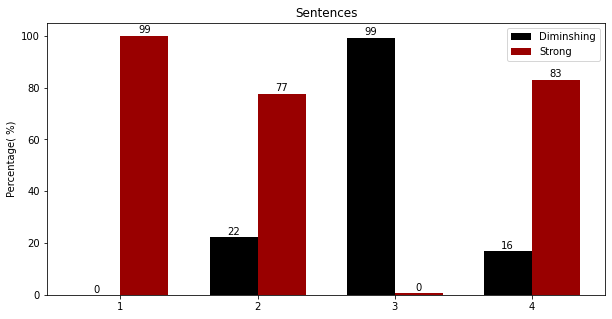

In [ ]:
import numpy as np
text = ["Do it now","I am want this now" , "I will try to solve this","I will solve this"]

# predict the label using the pipeline
print(text)
print("Predictions: ")
print (pipeline.predict(text))

####################################################################################################################
                       ## Remove this later
prob_Of_Each_Class = pipeline.predict_proba(text)

x= list(range(0,  len(text) ))
X = np.arange(1,len(text)+1)
y_strong= prob_Of_Each_Class[:,1]*100
y_diminishing=prob_Of_Each_Class[:,0]*100    

"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = len(X)
men_means = y_diminishing


ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(ind, men_means, width, color='black')

women_means = y_strong

rects2 = ax.bar(ind + width, women_means, width, color='#990000')
# add some text for labels, title and axes ticks
ax.set_ylabel('Percentage( %)')
ax.set_title('Sentences')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(X)

ax.legend((rects1[0], rects2[0]), ('Diminshing', 'Strong'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()
                       ## Remove this later
####################################################################################################################

In [ ]:
# print("Classes in order ",pipeline.classes_)

In [ ]:
# prob_Of_Each_Class = pipeline.predict_proba(text)
# # print('Predicted Probabilities: %s' % (prob_Of_Each_Class[:,1]*100)+"% strong")

# x= list(range(0,  len(text) ))
# X = np.arange(1,len(text)+1)
# y_strong= prob_Of_Each_Class[:,1]*100
# y_diminishing=prob_Of_Each_Class[:,0]*100


## Connect To Watson